In [403]:
import numpy as np
import random
from CompilerQC import Graph
from CompilerQC import core
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint
from CompilerQC import Polygons
from CompilerQC import Energy
from CompilerQC import MC
from scipy.special import binom
import networkx as nx
from networkx import bipartite

In [404]:
N = 7
graph = Graph.random(10)

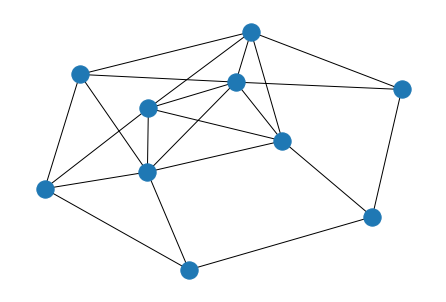

In [405]:
nx.draw(graph.to_nx_graph())

In [406]:
graph.C, graph.K

(13, 22)

In [407]:
from networkx.algorithms.isomorphism import GraphMatcher

def bf_find_all_bipartite_graphs(graph):
    """
    find all complete bipartite graphs in graph 
    by generating a bipartite graph of size i,j and 
    searching for it via the subgraph isomorphism 
    this if the brute force method for finding the 
    bipartite graphs
    """
    list_of_UV = []
    for i in range(2, N):
        for j in range(2, N):
            print(i,j, end='')
            S = core.complete_bipartite_graph(i, j)
            G = graph.to_nx_graph()
            K_nn = S
            GM = GraphMatcher(G, S)
            for m in GM.subgraph_monomorphisms_iter():
                reversed_mapping = {v: k for k, v in m.items()}
                K_nn = nx.relabel_nodes(S, reversed_mapping)
                # parts of bipartite graph
                U, V = bipartite.sets(K_nn)
                U, V = list(U), list(V)
                list_of_UV.append([U,V])
    return list_of_UV



In [436]:
list_of_UV = bf_find_all_bipartite_graphs(graph)
len(list_of_UV)

2 22 32 42 52 63 23 33 43 53 64 24 34 44 54 65 25 35 45 55 66 26 36 46 56 6

1104

In [409]:
def bf_find_several_bipartite_graphs(graph):
    """
    find all complete bipartite graphs in graph 
    by generating a bipartite graph of size i,j and 
    searching for it via the subgraph isomorphism 
    """
    list_of_UV = []
    for i in range(2, N):
        for j in range(2, N):
            print(i,j, end='')
            S = core.complete_bipartite_graph(i, j)
            if core.subgraph_is_monomorphic(graph.to_nx_graph(), S):
                UV = core.parts_of_complete_bipartite_graph(graph.to_nx_graph(), S)
                list_of_UV.append(UV)
    return list_of_UV
list_of_UV = bf_find_several_bipartite_graphs(graph)
len(list_of_UV)

2 22 32 42 52 63 23 33 43 53 64 24 34 44 54 65 25 35 45 55 66 26 36 46 56 6

6

In [437]:
sort_UV_by_len = [sorted(uv, key=len) for uv in list_of_UV] # sort sets UV, smaller set first
# remove double sets as [U, V] and [V, U]
dropped_duplicates_in_UV = []
for uv in sort_UV_by_len:
    if (
        [uv[0], uv[1]] not in dropped_duplicates_in_UV 
        and [uv[1], uv[0]] not in dropped_duplicates_in_UV
    ):
        dropped_duplicates_in_UV.append(uv)
dropped_duplicates_in_UV = np.array(dropped_duplicates_in_UV, dtype=object)


In [438]:
# remove [U', V'] if it is already part in a larger [U, V]
Us = np.array(dropped_duplicates_in_UV, dtype=object)[:,0]
Vs = np.array(dropped_duplicates_in_UV, dtype=object)[:,1]
setUs = list(map(set, Us))
setVs = list(map(set, Vs))
is_subsetu_u = np.array([[u_.issubset(u) for u in setUs] for u_ in setUs])
is_subsetu_v = np.array([[u_.issubset(v) for v in setVs] for u_ in setUs])
is_subsetv_u = np.array([[v_.issubset(u) for u in setUs] for v_ in setVs])
is_subsetv_v = np.array([[v_.issubset(v) for v in setVs] for v_ in setVs])

v_in_UV = np.logical_or(is_subsetv_u, is_subsetv_v)
u_in_UV = np.logical_or(is_subsetu_u, is_subsetu_v)
uv_already_in_UV = np.logical_and(v_in_UV, u_in_UV)
uv_already_in_UV = np.sum(uv_already_in_UV, axis=-1) > 1
unique_lists_of_UV = dropped_duplicates_in_UV[~uv_already_in_UV]

In [439]:
def get_sets_from_UV(list_of_UVs):  
    array_of_UVs = np.array(list_of_UVs, dtype=object)
    set_of_UVs = np.apply_along_axis(lambda x:[set(i) for i in x], -1, array_of_UVs)
    return set_of_UVs

In [440]:
unique_sets_of_UV = get_sets_from_UV(unique_lists_of_UV)

In [441]:
Us, Vs = unique_sets_of_UV.T
Vs

array([{4, 6}, {1, 3, 4}, {1, 2, 3}, {0, 5, 6}, {8, 2, 6}, {8, 1, 2},
       {8, 5, 7}, {1, 3, 5, 6}, {8, 2, 5}], dtype=object)

In [442]:
# seed longest rectengulat
max_v = max(Vs, key=len)
max_u = Us[np.where(Vs == max_v)][0]
already_in_max = [np.where(Vs == max_v)[0][0]]

max_u, max_v

({2, 8}, {1, 3, 5, 6})

In [443]:
# seed max(n * m)
mn = list(map(lambda uv: len(uv[0]) * len(uv[1]), unique_sets_of_UV))
max_idx = mn.index(max(mn))
max_v = Vs[max_idx]
max_u = Us[max_idx]
already_in_max = [max_idx]
max_u, max_v

({1, 3, 6}, {2, 5, 8})

In [444]:

def sort_unique_sets_of_UV(b: 'unique_sets_of_UV'):
    global max_u, max_v, already_in_max
    print(max_u, max_v)
    b = get_sets_from_UV([sorted(l, key=lambda x: len(set(x).intersection(max_v)) / len(x) ) for l in b])
    intersection_v_max_v = np.array(list(map(lambda uv: 10 if uv[1] == max_v else len(uv[1].intersection(max_v)) / len(max_v), b)))
    intersection_u_max_v = np.array(list(map(lambda uv: 10 if uv[0] == max_v else len(uv[0].intersection(max_v)) / len(max_v), b)))
    intersection_v_max_u = np.array(list(map(lambda uv: 10 if uv[1] == max_u else len(uv[1].intersection(max_u)) / len(max_u), b)))
    intersection_u_max_u = np.array(list(map(lambda uv: 10 if uv[0] == max_u else len(uv[0].intersection(max_u)) / len(max_u), b)))
    fr = list(intersection_u_max_u - intersection_v_max_u)
    fr = list(reversed(np.argsort(fr)))
    idx = [i for i in fr if i not in already_in_max][0]
    already_in_max.append(idx)
    if b[idx][1].intersection(max_u) > b[idx][0].intersection(max_u):
        b[idx][1], b[idx][0] = b[idx][0], b[idx][1]
    max_u  = set.union(b[idx][0], max_u)
    max_v = set.union(b[idx][1], max_v)
    b_old = b[:]
    b = get_sets_from_UV([sorted(l, key=lambda x: len(set(x).intersection(max_u)) / len(x), reverse=True) for l in b])
    if (b == b_old).all():
        print('foin',b)
        return b
    else:
        print('once more')
        return sort_unique_sets_of_UV(b)


In [445]:
UVs = sort_unique_sets_of_UV(unique_sets_of_UV)

{1, 3, 6} {8, 2, 5}
foin [[{4, 6} {2, 7}]
 [{1, 3, 4} {0, 2}]
 [{1, 2, 3} {0, 5}]
 [{0, 5, 6} {1, 2}]
 [{1, 5} {8, 2, 6}]
 [{5, 6} {8, 1, 2}]
 [{9, 6} {8, 5, 7}]
 [{1, 3, 5, 6} {8, 2}]
 [{1, 3, 6} {8, 2, 5}]]


In [446]:
Us, Vs = UVs.T
Vs

array([{2, 7}, {0, 2}, {0, 5}, {1, 2}, {8, 2, 6}, {8, 1, 2}, {8, 5, 7},
       {8, 2}, {8, 2, 5}], dtype=object)

In [447]:
from itertools import permutations


def find_ordering(main, subsets):
    for p in permutations(main):
        if all(any(set(p[i:i+len(s)]) == s 
                   for i in range(len(main) - len(s) + 1)) 
               for s in subsets):
            return p


print(find_ordering({x for sublist in Vs for x in sublist}, Vs))

None


In [422]:
from shapely.geometry import Point, LineString, Polygon

In [468]:
def energy(sets: 'Us or Vs', coords: 'list of integers'):
    """
    calculates the energy of the current coord node assignment
    """
    nodes = list({str(node) for subset in sets for node in subset})
    if len(set(coords)) < len(nodes):
        return 99999
    coords = list(zip(np.zeros(len(nodes)).astype(int), coords))
    nodes_coord_dict = dict(zip(nodes, coords))
    list_of_lengths = []
    for _set in sets:
        coords_of_single_set = list({coord for node, coord in nodes_coord_dict.items() if int(node) in _set})
        coords_of_single_set.sort(key=lambda x: x[1])
        
        if len(coords_of_single_set) > 2: 
            polygon = Polygon(coords_of_single_set)
            length = polygon.length - 2 * (len(coords_of_single_set) - 1)
        else:
            linestring = LineString(coords_of_single_set)
            length = linestring.length - 1
        list_of_lengths.append(length)
    list_of_lengths = np.array(list_of_lengths)
    list_of_weights = np.array(list(map(lambda uv: len(uv[0]) * len(uv[1]), UVs)))
    #list_of_weights = np.ones(len(sets))
    return np.dot(list_of_weights, list_of_lengths)

In [477]:
coords = [6, 1, 2, 8, 5, 7, 0]


In [478]:
Us
nodes = list({str(node) for subset in Vs for node in subset})
energy(Vs, coords), nodes

(290.0, ['5', '7', '1', '6', '8', '0', '2'])

 The best solution found:                                                                           
 [2. 3. 3. 5. 0. 1.]

 Objective function:
 99999


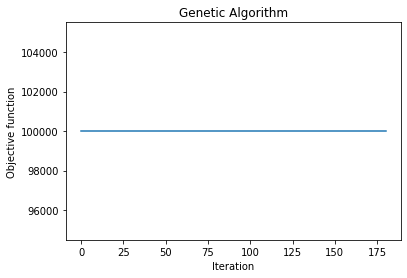

In [471]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(coords):
    return energy(Us, coords)

n = 6
varbound=np.array([[0,n-1]]*n)

model=ga(function=f,dimension=n,variable_type='int',variable_boundaries=varbound)

model.run()

In [495]:
from __future__ import print_function
import math
import random
from collections import defaultdict
from simanneal import Annealer




class TSP(Annealer):

    """
    Given the first or second sets of several bipartite core sets,
    this class merges them by using simulated annealing.
    """

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, UVs, sets, coords: list=None):
        """
        from the first or second sets, the unique nodes from the logical graph are extracted,
        coords of these nodes are initialized
        """
        self.sets = sets
        self.nodes = list({str(node) for subset in sets for node in subset})
        self.list_of_weights = np.array(list(map(lambda uv: len(uv[0]) * len(uv[1]), UVs)))
        if coords is None:
            coords = list(np.arange(len(self.nodes)))
        self.state = coords

    def move(self):
        """Swaps two  nodes """
        initial_energy = self.energy()

        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

        return self.energy() - initial_energy

    def energy(self):
        """
        calculates the energy of the current coord node assignment,
        important sets (measured by the size of the corresponding bipartite graph)
        have a heigher weight
        """
        coords = self.state
        sets = self.sets
        
        coords = list(zip(np.zeros(len(self.nodes)).astype(int), coords))

        nodes_coord_dict = dict(zip(self.nodes, coords))
        list_of_lengths = []
        for _set in sets:
            coords_of_single_set = list({coord for node, coord in nodes_coord_dict.items() if int(node) in _set})
            coords_of_single_set.sort(key=lambda x: x[1])

            if len(coords_of_single_set) > 2: 
                polygon = Polygon(coords_of_single_set)
                length = polygon.length - 2 * (len(coords_of_single_set) - 1)
            else:
                linestring = LineString(coords_of_single_set)
                length = linestring.length - 1
            list_of_lengths.append(length)
        list_of_lengths = np.array(list_of_lengths) 
        #list_of_weights = np.ones(len(sets))
        return np.dot(self.list_of_weights, list_of_lengths)
    
    
if __name__ == '__main__':

    # latitude and longitude for the twenty largest U.S. cities

    # initial state, a randomly-ordered itinerary
    
    tsp = TSP(UVs=UVs, sets=Us)
    tsp.set_schedule(tsp.auto(minutes=0.2))
    # since our state is just a list, slice is the fastest way to copy
    tsp.copy_strategy = "slice"
    state, e = tsp.anneal()

    print(state)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.87000         50.00    11.75%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.87000         38.00    13.21%     0.36%     0:00:09     0:00:00

[6, 0, 2, 3, 4, 5, 1, 7]


In [496]:
tsp.energy()

38.0

In [ ]:
tsp.state = [4, 5, 1, 0, 3, 6, 2]

In [497]:
tsp.sets

array([{4, 6}, {1, 3, 4}, {1, 2, 3}, {0, 5, 6}, {1, 5}, {5, 6}, {9, 6},
       {1, 3, 5, 6}, {1, 3, 6}], dtype=object)

In [498]:
tsp.nodes

['4', '9', '5', '6', '1', '3', '0', '2']

In [499]:
merged_ = np.zeros_like(tsp.state)
for i in range(len(merged_)):
    merged_[tsp.state[i]] = tsp.nodes[i] 
merged_

array([9, 0, 5, 6, 1, 3, 4, 2])

In [493]:
Vs

array([{2, 7}, {0, 2}, {0, 5}, {1, 2}, {8, 2, 6}, {8, 1, 2}, {8, 5, 7},
       {8, 2}, {8, 2, 5}], dtype=object)

In [500]:
UVs

array([[{4, 6}, {2, 7}],
       [{1, 3, 4}, {0, 2}],
       [{1, 2, 3}, {0, 5}],
       [{0, 5, 6}, {1, 2}],
       [{1, 5}, {8, 2, 6}],
       [{5, 6}, {8, 1, 2}],
       [{9, 6}, {8, 5, 7}],
       [{1, 3, 5, 6}, {8, 2}],
       [{1, 3, 6}, {8, 2, 5}]], dtype=object)